# 2025 Indy Monte Carlo Simulation

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
from collections import Counter

In [286]:
cup_roster = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Data/Master-Data/2025-cup-series-full-timers.txt")

In [287]:
simulation_data = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Data/Indy-2025/indy-sim-ready-data.csv")
for col in simulation_data.columns:
    if "Unnamed" in col:
        simulation_data = simulation_data.drop(columns=[col])
simulation_data.head()

,Driver,Avg Finish,Wins,Top 5's,DNF,Avg Rating,szn_Avg Finish,szn_Wins,szn_Top 5's,szn_Avg Rating,DNF_Prob,track_Laps Led Per Race,szn_Laps Led Per Race,Std Dev
0,Tyler Reddick,5.0,0,1,0,101.9,13.8,0,5,91.0,0.15,20.0,5.333333,2.5
1,Cole Custer,5.0,0,1,0,92.3,24.6,0,0,47.8,0.15,0.0,0.095238,2.5
2,Todd Gilliland,6.0,0,0,0,78.4,22.0,0,0,55.1,0.15,1.0,0.523810,2.5
3,Austin Cindric,7.0,0,0,0,60.3,20.3,1,1,77.6,0.15,0.0,11.952381,2.5
4,Christopher Bell,8.0,0,1,0,92.7,12.6,3,8,89.8,0.15,1.0,10.523810,2.5


In [288]:
display(simulation_data)

,Driver,Avg Finish,Wins,Top 5's,DNF,Avg Rating,szn_Avg Finish,szn_Wins,szn_Top 5's,szn_Avg Rating,DNF_Prob,track_Laps Led Per Race,szn_Laps Led Per Race,Std Dev
0,Tyler Reddick,5.0,0,1,0,101.9,13.8,0,5,91.0,0.150000,20.000000,5.333333,2.5
1,Cole Custer,5.0,0,1,0,92.3,24.6,0,0,47.8,0.150000,0.000000,0.095238,2.5
2,Todd Gilliland,6.0,0,0,0,78.4,22.0,0,0,55.1,0.150000,1.000000,0.523810,2.5
3,Austin Cindric,7.0,0,0,0,60.3,20.3,1,1,77.6,0.150000,0.000000,11.952381,2.5
4,Christopher Bell,8.0,0,1,0,92.7,12.6,3,8,89.8,0.150000,1.000000,10.523810,2.5
5,Noah Gragson,9.0,0,0,0,76.2,24.7,0,1,55.8,0.150000,3.000000,0.238095,2.5
6,Carson Hocevar,12.0,0,0,0,65.3,23.6,0,2,71.6,0.150000,0.000000,3.809524,2.5
7,Joey Logano,12.6,0,4,1,92.6,17.0,1,2,84.8,0.076923,6.153846,17.047619,3.5
8,Kyle Busch,12.8,2,5,2,102.6,17.0,0,2,72.4,0.117647,19.352941,2.952381,3.5
9,Daniel Suarez,12.8,0,0,0,69.2,21.6,0,1,60.6,0.030000,0.000000,0.952381,3.5


In [289]:
def simulate_race(df, track_stat_wgt, season_stat_wgt):
    finish_positions = []
    for _, row in df.iterrows():
        # calculate a performance bonus to add a weight to drivers who have performed well
        # at track in categories other than avg. finish
        performance_bonus_scale = 0.5  # increase effect of bonuses

        track_bonus = (
            0.3 * row['Wins'] +
            0.15 * row['track_Laps Led Per Race'] +
            0.1 * row['Avg Rating'] +
            0.1 * row["Top 5's"]
        )

        season_bonus = (
            0.3 * row['szn_Wins'] +
            0.15 * row['szn_Laps Led Per Race'] +
            0.1 * row['szn_Avg Rating'] +
            0.1 * row["szn_Top 5's"]
        )

        # weighted performance bonus
        performance_bonus = track_stat_wgt * track_bonus + season_stat_wgt * season_bonus


        # apply bonus: decrease average finish (but not below 1)
        adjusted_avg_finish = max(
        1,
        (
            track_stat_wgt * row['Avg Finish'] +
            season_stat_wgt * row['szn_Avg Finish']
        ) - performance_bonus * performance_bonus_scale
        )

        # quick check for a DNF
        dnf = np.random.poisson(row['DNF_Prob']) >= 1

        # mod finish position based on events
        if dnf:
            finish_pos = np.random.randint(len(df) + 1, len(df) + 6)
        else:
            finish_pos = np.random.normal(loc=adjusted_avg_finish, scale=row['Std Dev'])
            finish_pos = max(1, min(len(df), finish_pos))
        finish_positions.append((row['Driver'], finish_pos, dnf))
    
    # convert the list to a dataframe to sort and view easier
    results = pd.DataFrame(finish_positions, columns=['Driver', 'Finish_Pos', 'DNF'])
    
    # sort by DNF first (non-DNF comes first), then finish position
    results = results.sort_values(by=['DNF', 'Finish_Pos'], ascending=[True, True]).reset_index(drop=True)
    
    # add relative finishing position column
    results['rel_pos'] = results.index + 1
    
    # driver in position 0 is the winner of that simulation
    # winner = results.iloc[0]['Driver'] # old method to just find the winner, instead now pull a whole df each sim for all finishing posns
    return results

def run_simulations(df, num_simulations=10000, weight_lst=[0.5, 0.5]):
    # quick check to make sure weight_lst adds to 1
    if sum(weight_lst) != 1:
        raise Exception("Make sure weight params add to 1")

    # init tracking dictionaries
    results_tracker = {driver: [] for driver in df['Driver']}
    win_counts = {driver: 0 for driver in df['Driver']}
    dnf_counts = {driver: 0 for driver in df['Driver']}

    # do n simulations of race results and then track stats
    for _ in range(num_simulations):
        race_result = simulate_race(df, weight_lst[0], weight_lst[1])
        for idx, row in race_result.iterrows():
            driver = row['Driver']
            pos = row["rel_pos"]
            results_tracker[driver].append(pos)
            if row["DNF"]:
                dnf_counts[driver] += 1
        winner = race_result.iloc[0]['Driver']
        win_counts[winner] += 1

    # combine everything into final results, including statistics like avg finish and standard deviation of all finishes
    final_data = []
    for driver in df['Driver']:
        finishes = results_tracker[driver]
        avg_finish = np.mean(finishes)
        std_dev = np.std(finishes)
        wins = win_counts[driver]
        dnfs = dnf_counts[driver]
        win_prob = wins / num_simulations
        final_data.append((driver, wins, win_prob, avg_finish, std_dev, dnfs))

    # build final dataframe
    win_probs = pd.DataFrame(final_data, columns=['Driver', 'Wins', 'Win_Prob', 'Avg_Finish', 'Finish_StdDev', 'DNFs'])
    win_probs = win_probs.sort_values(by=['Wins', 'Avg_Finish'], ascending=[False, True]).reset_index(drop=True)
    return win_probs

In [290]:
# run the simulation n=10000 times
results = run_simulations(simulation_data, 10000, [0.3, 0.7])
display(results)

,Driver,Wins,Win_Prob,Avg_Finish,Finish_StdDev,DNFs
0,Christopher Bell,1775,0.1775,7.2466,9.798336,1412
1,Kyle Larson,1669,0.1669,10.7532,12.005228,2477
2,Tyler Reddick,1660,0.1660,7.0455,9.540662,1334
3,Denny Hamlin,1659,0.1659,7.3990,9.015797,1127
4,Chase Elliott,1547,0.1547,7.9683,9.607044,1355
5,William Byron,498,0.0498,13.7445,10.764210,2206
6,Chris Buescher,286,0.0286,13.8198,9.525740,1520
7,Joey Logano,241,0.0241,10.2657,7.605452,755
8,Chase Briscoe,181,0.0181,14.6925,9.185213,1371
9,Kyle Busch,141,0.0141,12.0075,8.311224,1118


In [291]:
results_with_nums = results.merge(cup_roster[['Driver', 'Car No.']], on='Driver', how='left')
top_10 = results_with_nums.sort_values(by='Win_Prob', ascending=False).head(10).reset_index(drop=True)
top_10

,Driver,Wins,Win_Prob,Avg_Finish,Finish_StdDev,DNFs,Car No.
0,Christopher Bell,1775,0.1775,7.2466,9.798336,1412,20
1,Kyle Larson,1669,0.1669,10.7532,12.005228,2477,5
2,Tyler Reddick,1660,0.1660,7.0455,9.540662,1334,45
3,Denny Hamlin,1659,0.1659,7.3990,9.015797,1127,11
4,Chase Elliott,1547,0.1547,7.9683,9.607044,1355,9
5,William Byron,498,0.0498,13.7445,10.764210,2206,24
6,Chris Buescher,286,0.0286,13.8198,9.525740,1520,17
7,Joey Logano,241,0.0241,10.2657,7.605452,755,22
8,Chase Briscoe,181,0.0181,14.6925,9.185213,1371,19
9,Kyle Busch,141,0.0141,12.0075,8.311224,1118,8


In [292]:
# really cool function to extract most common color from a png: you'll see it below
def get_main_hex_color(url):
    resp = requests.get(url)
    img = Image.open(BytesIO(resp.content)).convert('RGBA')
    img = img.resize((50, 50))  # resize to reduce TC
    pixels = list(img.getdata())

    # filter out transparent pixels
    opaque_pixels = [pixel[:3] for pixel in pixels if pixel[3] != 0]
    if not opaque_pixels:
        return None

    color_counts = Counter(opaque_pixels).most_common()

    def is_black_or_white(rgb):
        return rgb == (0, 0, 0) or rgb == (255, 255, 255)

    # find most common color that is not black or white
    for color, count in color_counts:
        if not is_black_or_white(color):
            most_common_color = color
            break
    else:
        # fallback if all are black or white
        most_common_color = color_counts[0][0]

    return '#{:02x}{:02x}{:02x}'.format(*most_common_color)

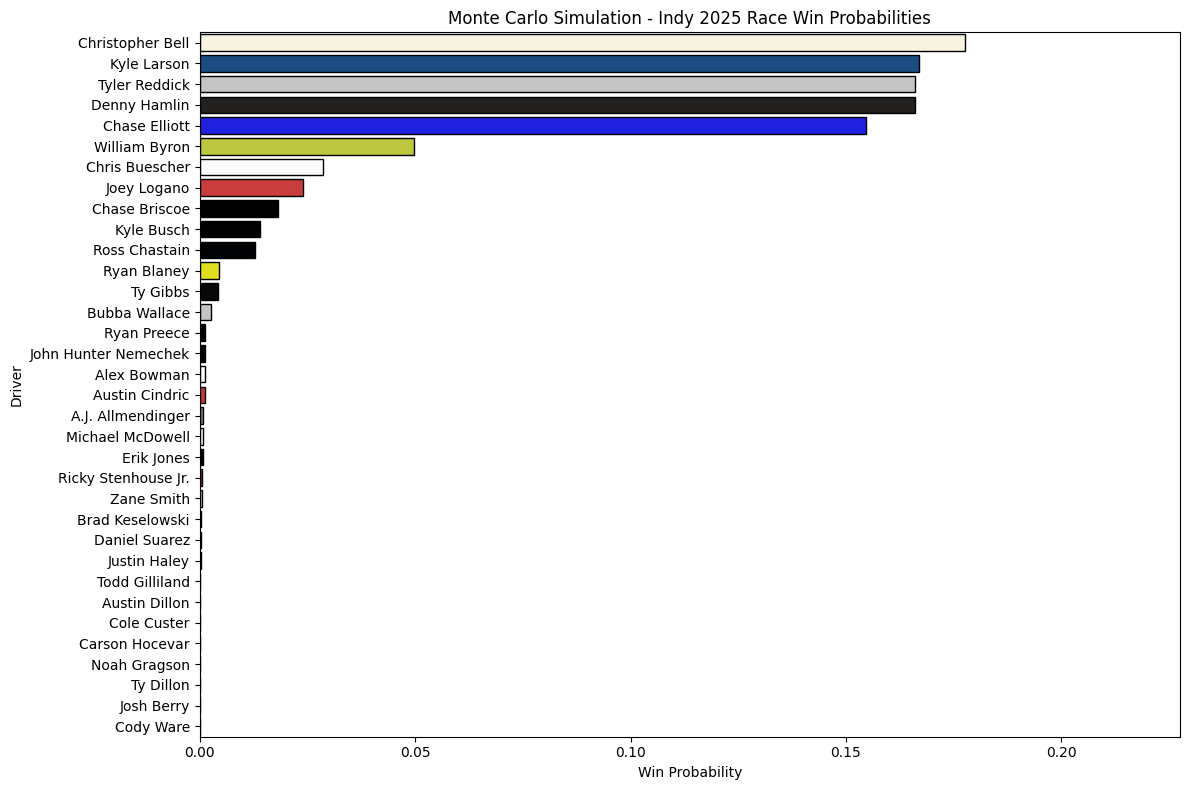

In [293]:
bar_colors = []

for idx, row in results.iterrows():
    car_num = cup_roster.loc[cup_roster['Driver'] == row['Driver'], 'Car No.'].values[0]
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=results,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
    
plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Indy 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

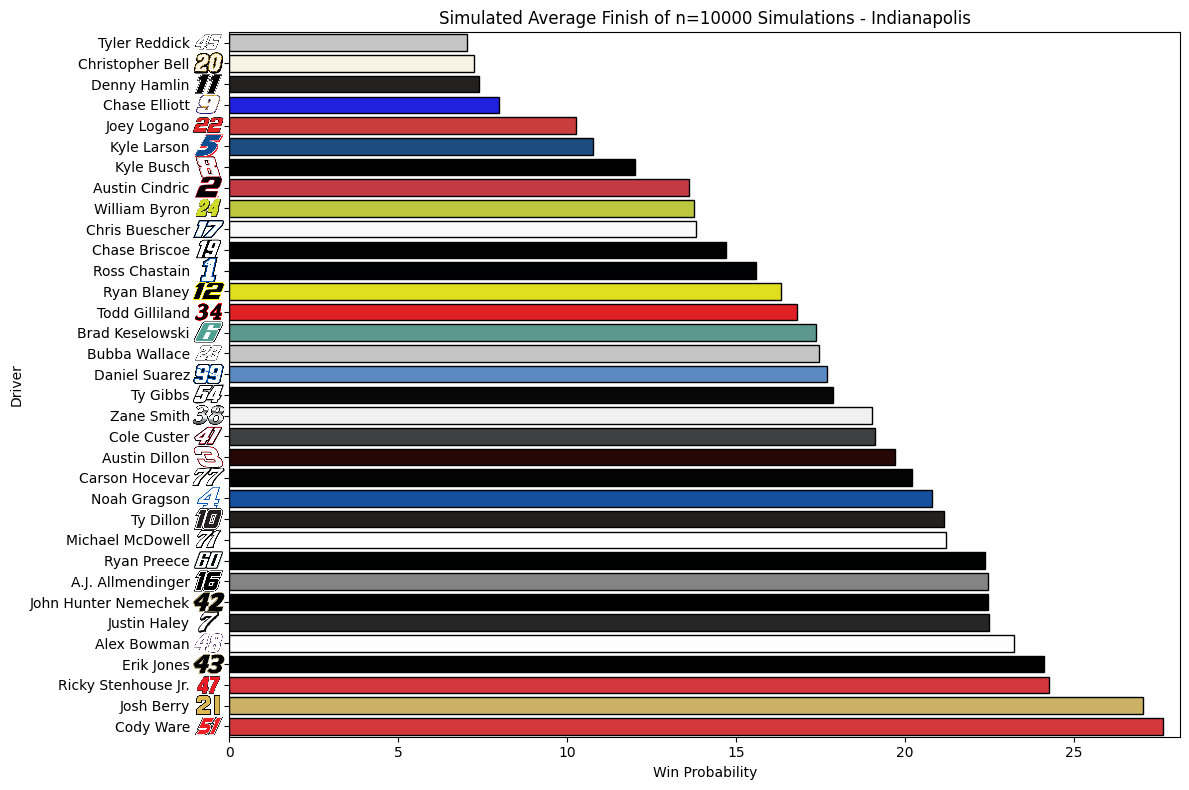

In [309]:
bar_colors = []

for idx, row in results.sort_values(by="Avg_Finish", ascending=True).iterrows():
    car_num = cup_roster.loc[cup_roster['Driver'] == row['Driver'], 'Car No.'].values[0]
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=results.sort_values(by="Avg_Finish", ascending=True),
    x='Avg_Finish',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

for i, car_num in enumerate(results_with_nums.sort_values(by="Avg_Finish", ascending=True)['Car No.']):
    response = requests.get(f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png")
    image = Image.open(BytesIO(response.content))
    im = OffsetImage(image, zoom=0.15)
    ab = AnnotationBbox(im, (0, i), xybox=(-15, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Simulated Average Finish of n=10000 Simulations - Indianapolis')
plt.xlim(0, results['Avg_Finish'].max() + 0.5)

ax = plt.gca()
ax.tick_params(axis='y', pad=25)
plt.tight_layout()
plt.show()

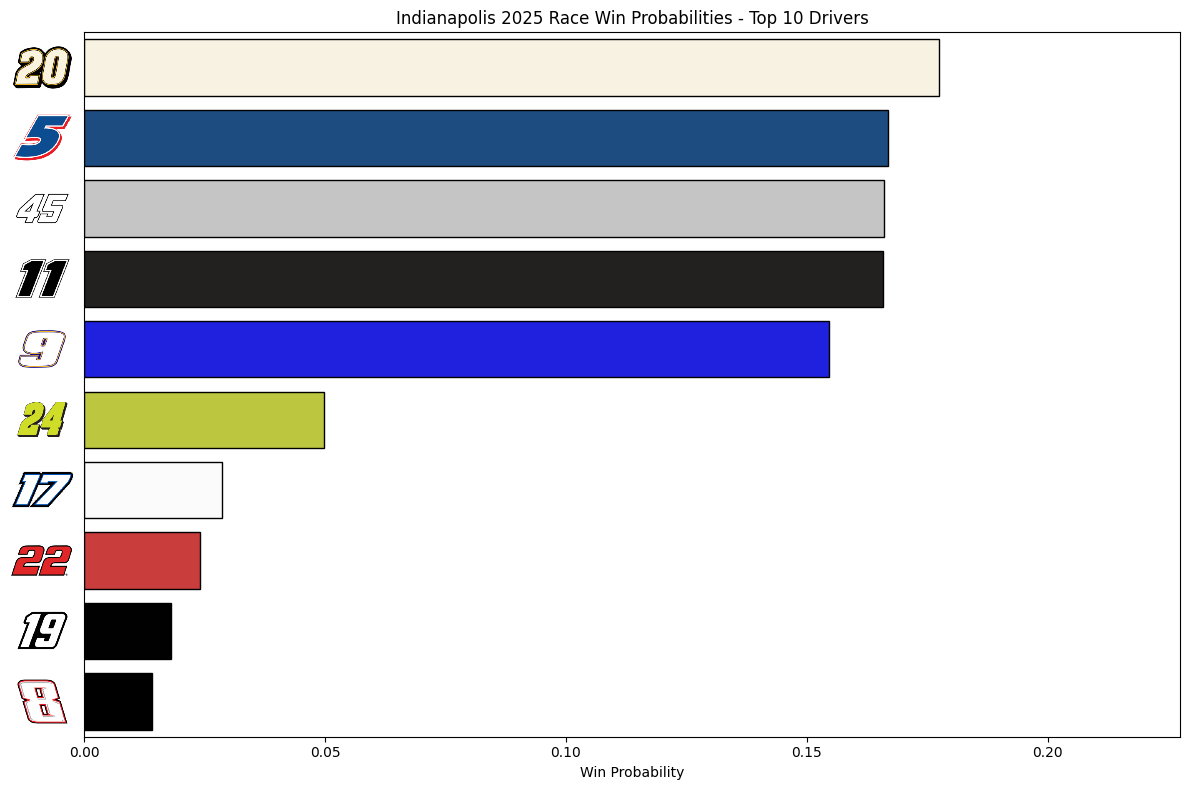

In [ ]:
# define colors from driver num logo using function above 
bar_colors = []

for idx, row in top_10.iterrows():
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{row['Car No.']}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=top_10,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

# add black outline
for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.yticks([])

plt.xlabel('Win Probability')
plt.ylabel('')
plt.title('Indianapolis 2025 Race Win Probabilities - Top 10 Drivers')
plt.xlim(0, top_10['Win_Prob'].max() + 0.05)

# Add car number images
for i, car_num in enumerate(top_10['Car No.']):
    response = requests.get(f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png")
    image = Image.open(BytesIO(response.content))
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (0, i), xybox=(-30, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()